## Import necessary packages

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from model import SiameseNetwork
from loss import ContrastiveLoss
from dataset import ATATContrast
from torchsummary import summary
from matplotlib import pyplot as plt
import os
from glob import glob
import random
from sklearn.metrics import classification_report
import shutil
from tqdm import tqdm

# Prepare the data file

In [2]:
os.mkdir("train_test_val")
os.mkdir("train_test_val/train")
os.mkdir("train_test_val/test")
os.mkdir("train_test_val/val")

data=os.listdir("../archive (2)")
data.remove("README")

#train
rs=random.sample(data,32)
for i in rs:
    shutil.copytree(f"../archive (2)/{i}",f"train_test_val/train/{i}")
    data.remove(i)

#test
rs=random.sample(data,4)
for i in rs:
    shutil.copytree(f"../archive (2)/{i}",f"train_test_val/test/{i}")
    data.remove(i)

#valid
rs=random.sample(data,4)
for i in rs:
    shutil.copytree(f"../archive (2)/{i}",f"train_test_val/val/{i}")
    data.remove(i)

In [3]:
# os.mkdir("train_test_val")
# os.mkdir("train_test_val/train")
# os.mkdir("train_test_val/test")
# os.mkdir("train_test_val/val")

# for i in ["train","test","val"]:
#     for j in range(1,41):
#         os.mkdir(f"train_test_val/{i}/s{j}")
        
# for i in os.listdir("../archive (2)"):
#     if i == ".DS_Store":
#         continue
#     if i =="README":
#         continue
   
#     images=glob(f"../archive (2)/{i}/*.pgm")
   
#     #train
#     for img in random.sample(images, 6):
#         shutil.copyfile(img, f"train_test_val/train/{i}/{img.split('/')[-1]}")
#         images.remove(img)
       
#     #test
#     for img in random.sample(images, 2):
#         shutil.copyfile(img, f"train_test_val/test/{i}/{img.split('/')[-1]}")
#         images.remove(img)
   
#     #val
#     for img in random.sample(images, 2):
#         shutil.copyfile(img, f"train_test_val/val/{i}/{img.split('/')[-1]}")
#         images.remove(img)
   


## Initialize batch size and hyperparameters
The margin and threshold were changed to perform well on the validation set

In [4]:
path = 'train_test_val'

## Initialize parameters
bs = 32
lr = 0.007
margin = 1.0
epochs = 20

## Initialize network variables

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("the device being used is:",device)

## Initialize network
model = SiameseNetwork()
model = model.to(device)

## Initialize optimizer
optim = torch.optim.Adam(model.parameters(),lr=lr)

## Initialize loss
criterion = ContrastiveLoss(margin)

the device being used is: mps


/Users/yazeed/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Create Datasets and Dataloaders

In [6]:
## Initialize datasets and dataloaders
train_transforms = torchvision.transforms.Compose([
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomRotation(25),
            torchvision.transforms.Grayscale(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.5], [0.5])
        ])

valid_transforms = torchvision.transforms.Compose([
            torchvision.transforms.Grayscale(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.5], [0.5])
        ])

test_transforms = torchvision.transforms.Compose([
            torchvision.transforms.Grayscale(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.5], [0.5])
        ])

train_ds = ATATContrast(ImageFolder(root = path + '/train',transform=train_transforms))
valid_ds = ATATContrast(ImageFolder(root = path + '/val',transform=valid_transforms))
test_ds = ATATContrast(ImageFolder(root = path + '/test',transform=test_transforms))

train_dl = DataLoader(train_ds,batch_size=bs)
valid_dl = DataLoader(valid_ds,batch_size=bs)
test_dl = DataLoader(test_ds,batch_size=bs)

## Train the model

In [7]:
train_loss = []
valid_loss = []
for epoch in range(epochs):
    train_epoch_loss = 0
    model.train()    
      
    for i,(input1,input2,target) in enumerate(tqdm(train_dl, colour = 'GREEN',desc="Training  ",ncols=100)):
        optim.zero_grad()
        output1,output2 = model(input1.to(device),input2.to(device))        
        loss = criterion(output1,output2,target.to(device))
        train_epoch_loss += loss.item()
        loss.backward()
        optim.step()
    
    train_epoch_loss /= len(train_ds)
    train_loss.append(train_epoch_loss)    

    valid_epoch_loss = 0

    model.eval()

    for i,(input1,input2,target) in enumerate(tqdm(valid_dl, colour = 'GREEN',desc="Validating",ncols=100)):
        output1,output2 = model(input1.to(device),input2.to(device))
        loss = criterion(output1,output2,target.to(device))
        valid_epoch_loss += loss.item()


    valid_loss.append(valid_epoch_loss)

    print("Epoch [{}/{}] ----> Training loss :{} \n".format(epoch+1,epochs,train_epoch_loss))
    print("Validation loss :{}\n".format(valid_epoch_loss))

Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.82it/s]


Epoch [1/20] ----> Training loss :0.040395713644102216 

Validation loss :0.39257618971168995



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.12it/s]


Epoch [2/20] ----> Training loss :0.008767422195523978 

Validation loss :0.36979028582572937



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.86it/s]


Epoch [3/20] ----> Training loss :0.0059455181937664746 

Validation loss :0.19302714336663485



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.12it/s]


Epoch [4/20] ----> Training loss :0.004275480669457465 

Validation loss :0.13009718619287014



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.03it/s]


Epoch [5/20] ----> Training loss :0.0029417587677016853 

Validation loss :0.19850408658385277



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.84it/s]


Epoch [6/20] ----> Training loss :0.0023044757661409678 

Validation loss :0.1996554732322693



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.20it/s]


Epoch [7/20] ----> Training loss :0.0017763706826372072 

Validation loss :0.5829546749591827



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.99it/s]


Epoch [8/20] ----> Training loss :0.0014403936162125318 

Validation loss :0.4349445104598999



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.00it/s]


Epoch [9/20] ----> Training loss :0.0010113052689121106 

Validation loss :0.39009691774845123



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.04it/s]


Epoch [10/20] ----> Training loss :0.0007367622863966971 

Validation loss :0.6671120524406433



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s]


Epoch [11/20] ----> Training loss :0.0006147020059870556 

Validation loss :0.8037557005882263



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.94it/s]


Epoch [12/20] ----> Training loss :0.0005620342446491123 

Validation loss :0.4904685318470001



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.91it/s]


Epoch [13/20] ----> Training loss :0.00047668635961599647 

Validation loss :0.766447514295578



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.21it/s]


Epoch [14/20] ----> Training loss :0.00036418483359739183 

Validation loss :0.63120037317276



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.55it/s]


Epoch [15/20] ----> Training loss :0.00042669790345826184 

Validation loss :0.5865734964609146



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.00it/s]


Epoch [16/20] ----> Training loss :0.00031423852778971194 

Validation loss :0.4010925889015198



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.07it/s]


Epoch [17/20] ----> Training loss :0.00036055911768926305 

Validation loss :0.5662987232208252



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.98it/s]


Epoch [18/20] ----> Training loss :0.00027120905870106073 

Validation loss :0.8420293033123016



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.57it/s]


Epoch [19/20] ----> Training loss :0.00034587896952871234 

Validation loss :0.8551318049430847



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.10it/s]

Epoch [20/20] ----> Training loss :0.0003037961985683069 

Validation loss :0.5043188184499741



## Plot losses

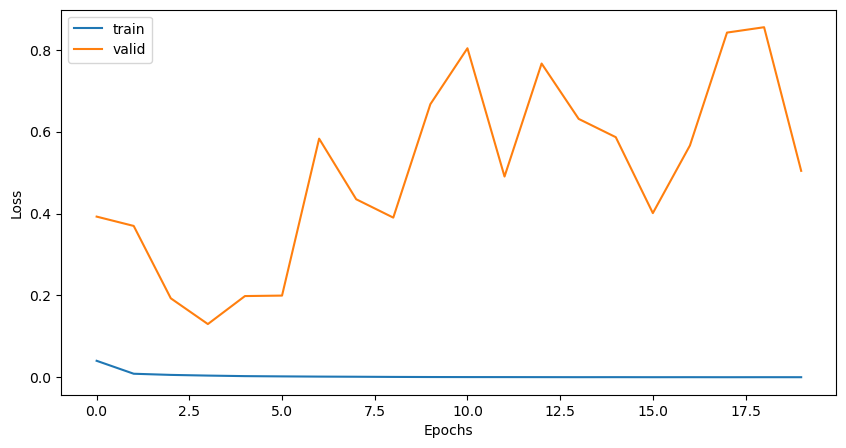

In [8]:
plt.figure(figsize = (10,5))
plt.plot(train_loss,label = 'train')
plt.plot(valid_loss,label = 'valid')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

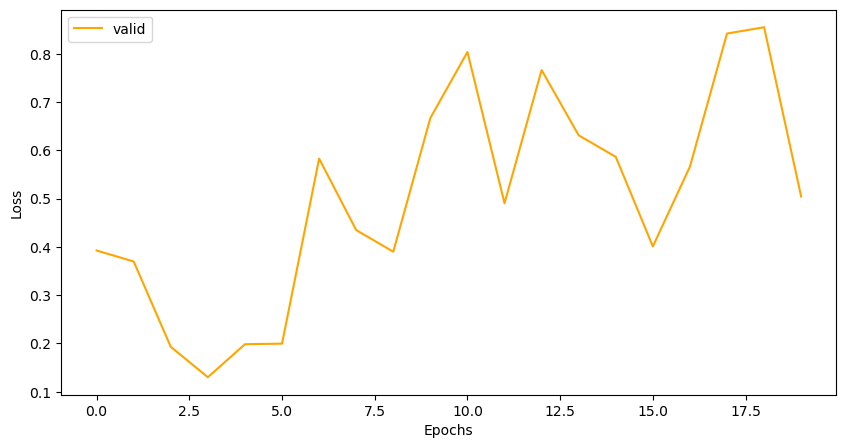

In [9]:
plt.figure(figsize = (10,5))
plt.plot(valid_loss,label = 'valid',color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

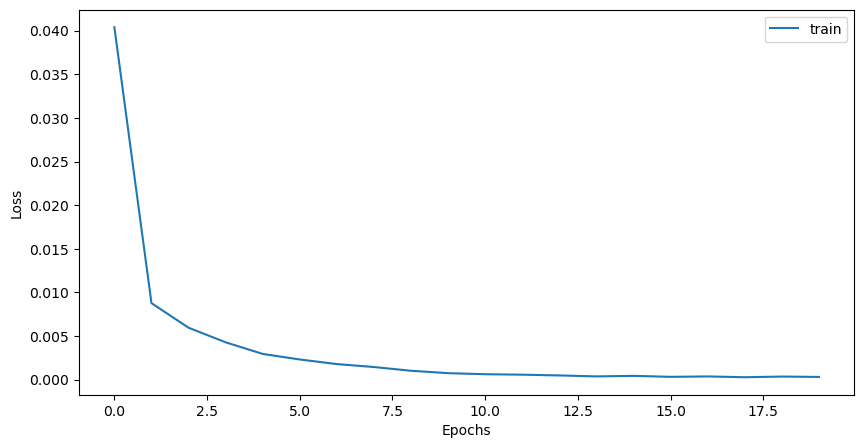

In [10]:
plt.figure(figsize = (10,5))
plt.plot(train_loss,label = 'train')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Plot images from test set and compare distances

In [11]:
def show(img,ax,d):
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    ax.set_title("Dissimilarity:"+str(round(d[0],5)),fontweight = "bold", size = 24)
    ax.set_xticks([])
    ax.set_yticks([])

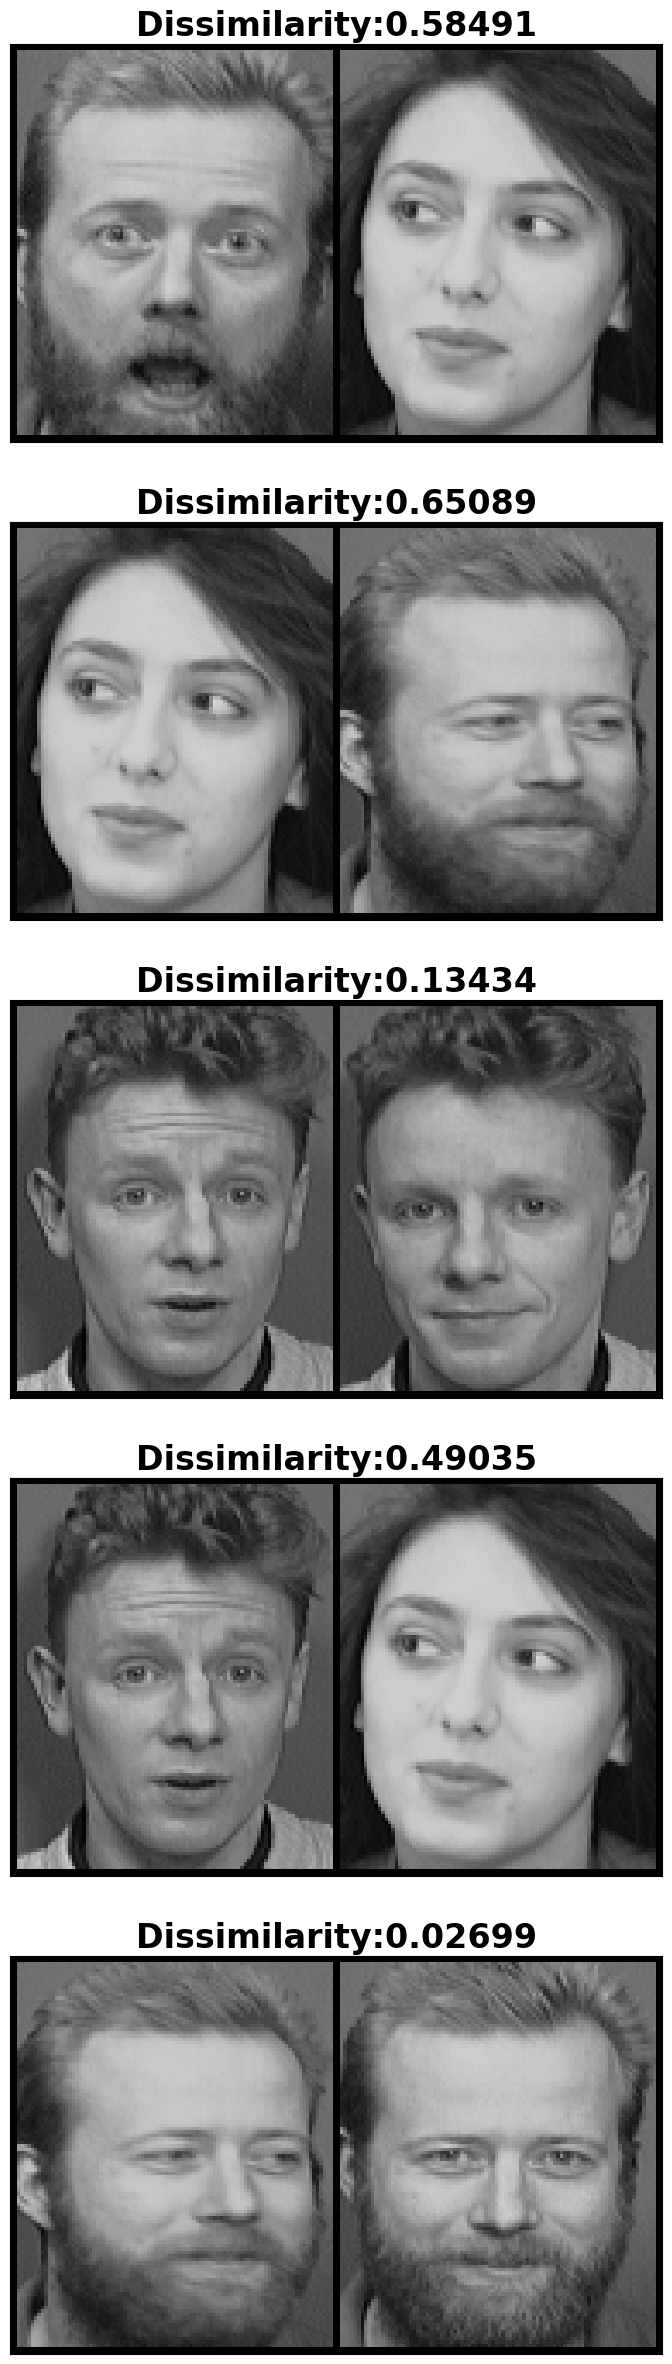

In [62]:
invTrans = torchvision.transforms.Compose([ torchvision.transforms.Normalize(mean = [ 0.],
                                                     std = [ 1/0.5]),
                                torchvision.transforms.Normalize(mean = [ -0.5],
                                                     std = [ 1.]),
                               ])

fig,ax = plt.subplots(5,1,figsize = (30,30))
for i in range(5):
    idx = np.random.randint(0,len(test_ds))
    input1,input2,target = test_ds[idx]
    model=model.to(device)
    output1,output2 = model(input1.unsqueeze(0).to(device),input2.unsqueeze(0).to(device))
    input1=invTrans(input1)
    input2=invTrans(input2)
    grid = torchvision.utils.make_grid([input1,input2])
    euclidean_distance = F.pairwise_distance(output1,output2)

    show(grid,ax[i],euclidean_distance.cpu().detach().numpy())
plt.show()

In [28]:
threshold=0.2

In [29]:
model=model.to(device)
preds=[]
actual=[]
for input1,input2,target in train_ds:
    actual.append(target)
    output1,output2 = model(input1.unsqueeze(0).to(device),input2.unsqueeze(0).to(device))
    pred=int(F.pairwise_distance(output1,output2)>threshold)
    preds.append(pred)
    
print(classification_report(preds,actual))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       128
           1       1.00      0.91      0.95       192

    accuracy                           0.95       320
   macro avg       0.94      0.96      0.95       320
weighted avg       0.95      0.95      0.95       320



In [30]:
model=model.to(device)
preds=[]
actual=[]
for input1,input2,target in test_ds:
    actual.append(target)
    output1,output2 = model(input1.unsqueeze(0).to(device),input2.unsqueeze(0).to(device))
    pred=int(F.pairwise_distance(output1,output2)>threshold)
    preds.append(pred)
    
print(classification_report(preds,actual))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.95      0.97        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



In [57]:
model=model.to(device)
preds=[]
actual=[]
for input1,input2,target in valid_ds:
    actual.append(target)
    output1,output2 = model(input1.unsqueeze(0).to(device),input2.unsqueeze(0).to(device))
    pred=int(F.pairwise_distance(output1,output2)>threshold)
    preds.append(pred)
    
print(classification_report(preds,actual))

              precision    recall  f1-score   support

           0       0.89      0.73      0.80        22
           1       0.73      0.89      0.80        18

    accuracy                           0.80        40
   macro avg       0.81      0.81      0.80        40
weighted avg       0.82      0.80      0.80        40



## Save the trained model for future usage

In [17]:
torch.save(model.state_dict(),'./siameseNetowrk_final.pt')

In [18]:
new_model = SiameseNetwork()
new_model.load_state_dict(torch.load('./siameseNetowrk_final.pt'))
new_model.eval()

/Users/yazeed/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


SiameseNetwork(
  (resnet): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(